In [ ]:
!pip install Crypto
!pip install -r requirements.txt
# make sure you have sports_entropy_prng.py and requirements.txt in directory for sports PRNG to work

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 15.0 MB/s eta 0:00:00
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [1]:
# define plotting and statistics functions

import requests
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import urllib3
urllib3.disable_warnings()

def analyze_results(numbers): #statistical plots
    if not numbers:
        print("No numbers generated!")
        return

    plt.figure(figsize=(15,5))

    # Value histogram
    plt.subplot(1,3,1)
    plt.hist(numbers, bins=256)
    plt.title("Byte Distribution")

    # Sequence plot
    plt.subplot(1,3,2)
    plt.plot(numbers[:200], 'b-', alpha=0.5)
    plt.title("Sequence Plot")

    # Autocorrelation plot
    plt.subplot(1,3,3)
    plt.acorr(np.array(numbers)-127.5, maxlags=20)
    plt.title("Autocorrelation")
    plt.tight_layout()
    plt.show()

def analyze_randomness(numbers): #computes randomness metrics
    numbers = np.array(numbers)

    # 1. Chi-Square Test (Tests for uniformity)
    freq, _ = np.histogram(numbers, bins=256, range=(0, 256))
    chi_score, p_value = chisquare(freq)
    print(f"\nChi-Square Test: χ² = {chi_score:.2f}, p = {p_value:.4f}")
    print("→ p > 0.05 suggests uniform distribution" if p_value > 0.05 else "→ WARNING: Non-uniform distribution (p ≤ 0.05)")

    # 2. 1-Bit Test
    bits = ''.join([format(x, '08b') for x in numbers])
    ones = bits.count('1')
    zeros = len(bits)-ones
    bit_bias = abs(ones-zeros) / len(bits)
    print(f"\n1-Bit Test: 0s= {zeros}, 1s= {ones}, Bias= {bit_bias:.4f}")
    print("→ Bias ≈ 0.0 indicates balanced bits" if bit_bias < 0.01 else "→ WARNING: Significant bit bias")

    # 3. Shannon Entropy (tests unpredictability)
    _, total_counts = np.unique(numbers, return_counts=True)
    probability = total_counts / len(numbers)
    entropy = -np.sum(probability * np.log2(probability))
    print(f"\nShannon Entropy: {entropy:.4f} bits/byte")
    print(f"→ Max = 8.0, Good ≥ 7.9, Weak ≤ 7.5")

    # 4. Autocorrelation Test (tests independence)
    autocorr = np.correlate(numbers - np.mean(numbers), numbers - np.mean(numbers), mode='full')
    autocorr = autocorr[len(autocorr)//2:] / np.max(autocorr)  # normalize
    lag1 = autocorr[1]
    print(f"\nAutocorrelation (Lag-1): {lag1:.4f}")
    print("→ |r| < 0.1 suggests independence" if abs(lag1) < 0.1 else "→ WARNING: Sequential correlation detected")

    # Visualization
    plt.figure(figsize=(15, 10))

    # Histogram plot
    plt.subplot(2, 2, 1)
    plt.hist(numbers, bins=50, density=True, alpha=0.7, color='blue')
    plt.title("Distribution (Uniformity Check)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Bit bias plot
    plt.subplot(2, 2, 2)
    plt.bar(['0', '1'], [zeros, ones], color=['red', 'green'])
    plt.title("1-Bit Test (Balance Check)")
    plt.ylabel("Count")

    # Autocorrelation plot
    plt.subplot(2, 2, 3)
    plt.stem(autocorr[:20], markerfmt='C0o', linefmt='C0-', basefmt='C7-')
    plt.title("Autocorrelation (Independence Check)")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")

    # Running average (Convergence) plot
    plt.subplot(2, 2, 4)
    running_avg = np.cumsum(numbers) / (np.arange(len(numbers)) + 1)
    plt.plot(running_avg, color='purple')
    plt.axhline(127.5, linestyle='--', color='gray')
    plt.title("Running Average (Convergence to 127.5)")
    plt.xlabel("Sample")
    plt.ylabel("Mean")

    plt.tight_layout()
    plt.show()

Generated 512-bit seed: 17befb60ad90406c069322a34d8fa25618cb6849f97ebe8753f4e05811dec31eb5659a052cf09f384f45fc811aaa6a5df56c7bf93788cb14666e43e55c867bda
64 random bytes: a729dbaa9c3ca266cc6649f0492b7e302ba89328ccad321dbf8f54e9fe6b79b9a323ea8e3d46c688b0a27dff90ec22e188f0d097cda14f7cfd7175c2463f8413
First 20 numbers: [167, 41, 219, 170, 156, 60, 162, 102, 204, 102, 73, 240, 73, 43, 126, 48, 43, 168, 147, 40]
Mean: 137.80 (Expected: ~127.5)
Std Dev: 67.19 (Expected: ~73.9)


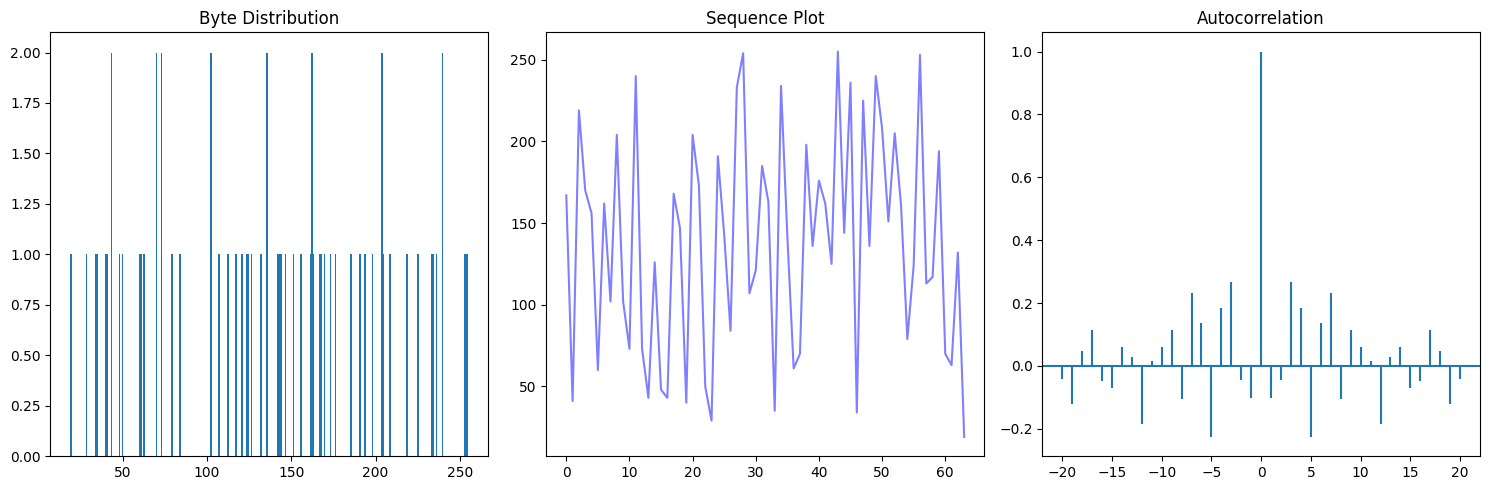


Chi-Square Test: χ² = 256.00, p = 0.4706
→ p > 0.05 suggests uniform distribution

1-Bit Test: 0s= 250, 1s= 262, Bias= 0.0234
→ WARNING: Significant bit bias

Shannon Entropy: 5.7500 bits/byte
→ Max = 8.0, Good ≥ 7.9, Weak ≤ 7.5

Autocorrelation (Lag-1): -0.1297
→ WARNING: Sequential correlation detected


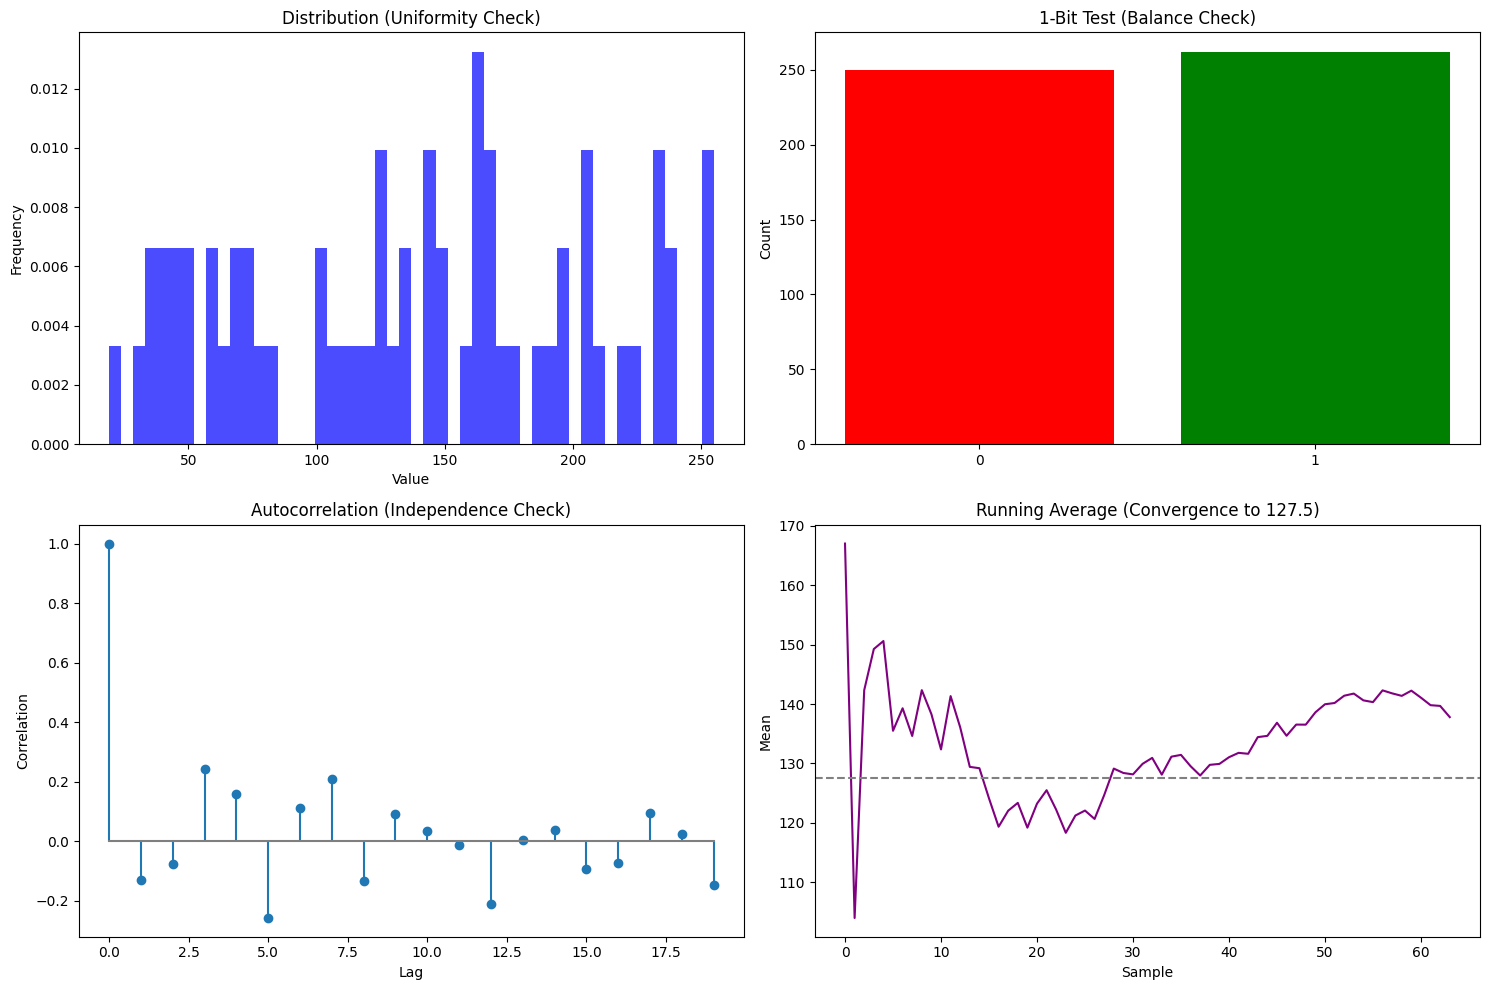

In [ ]:
# demo for sports prng (must have sports_entropy_prny.py and requirements.txt in directory)
import os
import sports_entropy_prng as se
os.environ['APISPORTS_KEY'] = "YOUR_API_KEY_HERE"
os.environ['SPORTMONKS_KEY'] = "YOUR_API_KEY_HERE"
os.environ['SPORTSDATAIO_KEY'] = "YOUR_API_KEY_HERE"

seed = se.gen_seed()
print("Generated 512-bit seed:", seed.hex())
rng = se.DRBG(seed)
random_bytes = rng.random_bytes(64)
print("64 random bytes:", random_bytes.hex())
random_numbers = [x % 256 for x in random_bytes]


if random_numbers:
    print(f"First 20 numbers: {random_numbers[:20]}")
    print(f"Mean: {np.mean(random_numbers):.2f} (Expected: ~127.5)")
    print(f"Std Dev: {np.std(random_numbers):.2f} (Expected: ~73.9)")
    analyze_results(random_numbers)
    analyze_randomness(random_numbers)
else:
    print("Failed to generate numbers.")

Generating combined random numbers...
First 20 numbers: [137, 48, 126, 126, 242, 126, 228, 4, 183, 21, 252, 238, 103, 239, 137, 122, 21, 192, 161, 179]
Mean: 132.56 (Expected: ~127.5)
Std Dev: 74.36 (Expected: ~73.9)


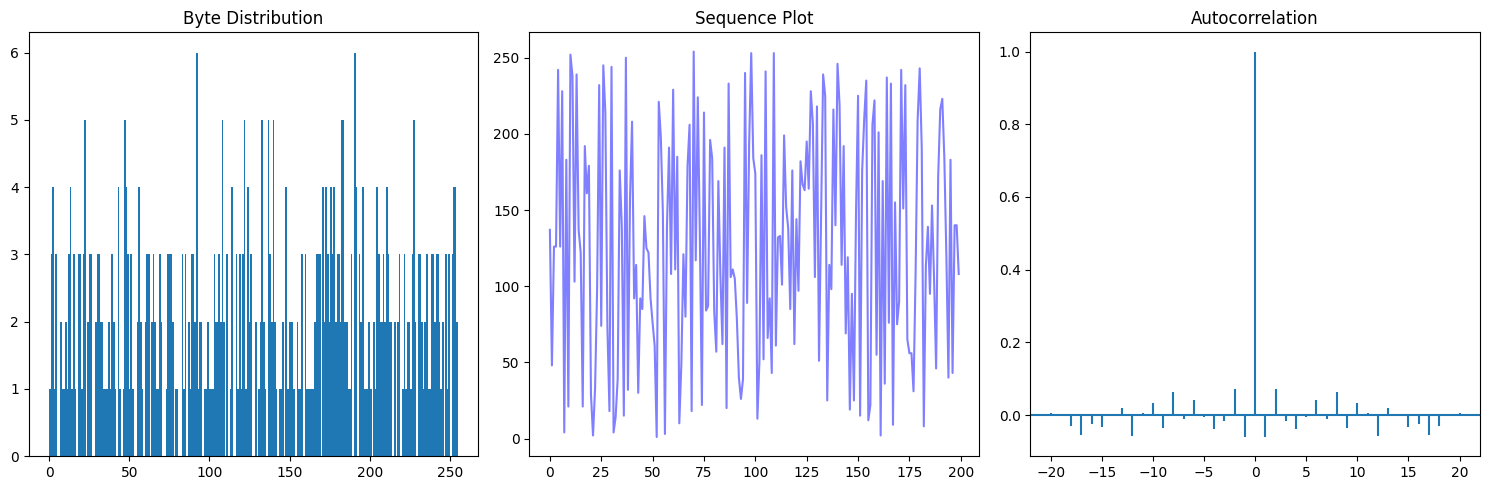


Chi-Square Test: χ² = 246.50, p = 0.6373
→ p > 0.05 suggests uniform distribution

1-Bit Test: 0s= 1957, 1s= 2043, Bias= 0.0215
→ WARNING: Significant bit bias

Shannon Entropy: 7.5690 bits/byte
→ Max = 8.0, Good ≥ 7.9, Weak ≤ 7.5

Autocorrelation (Lag-1): -0.0655
→ |r| < 0.1 suggests independence


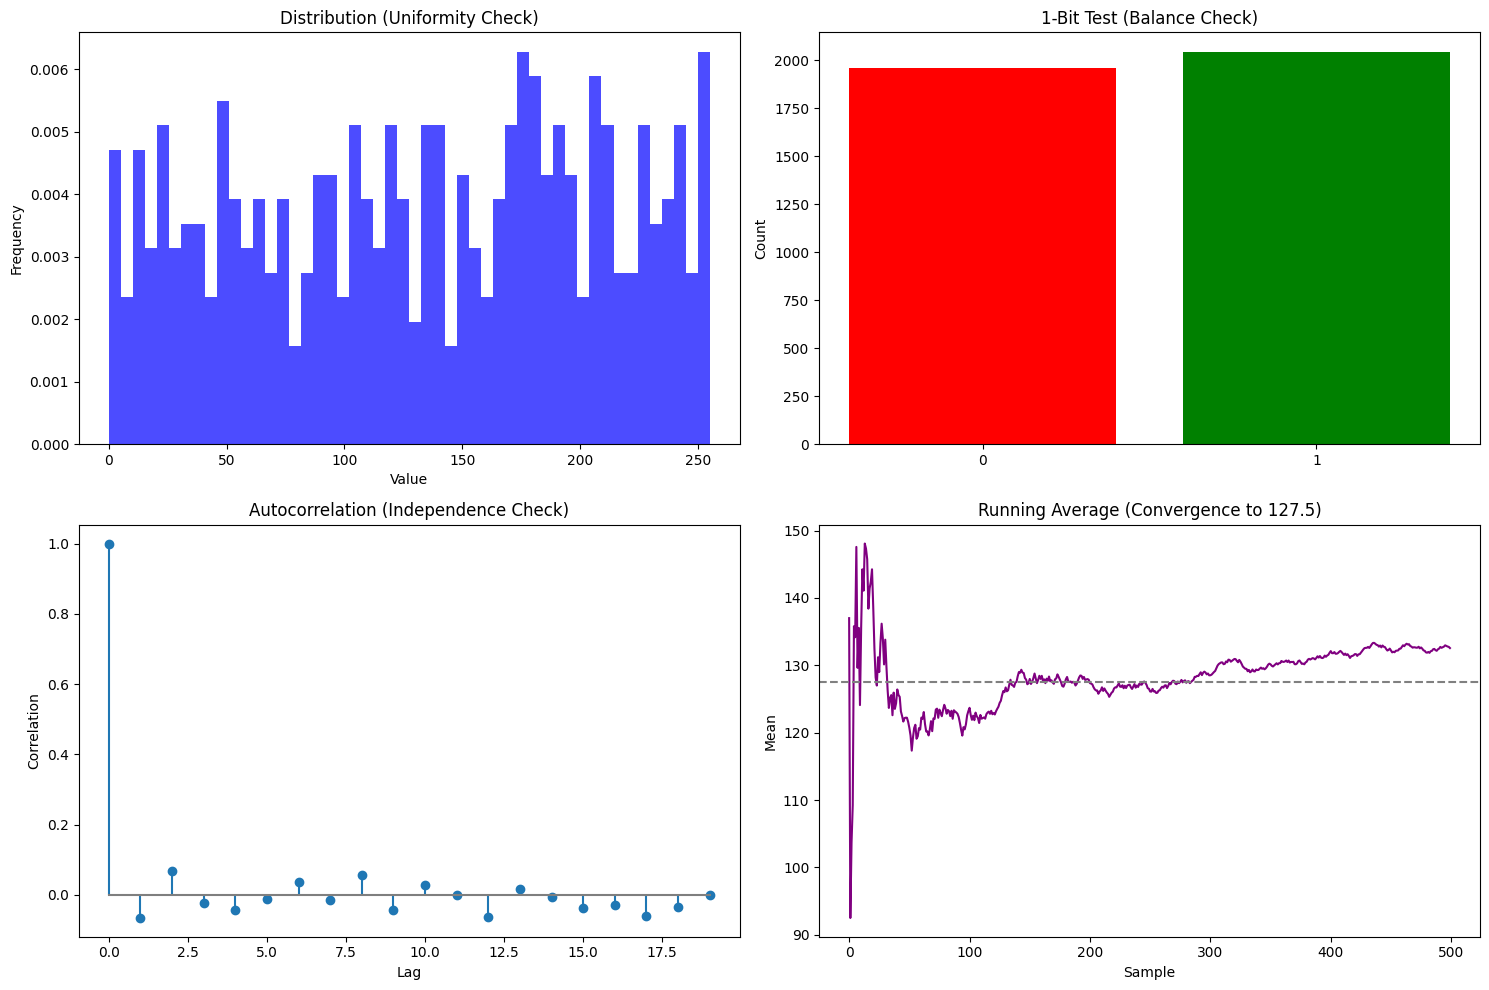

In [ ]:
# This version combines only the CosmicRayPRNG with the OpenAIPRNG
# (I think these are the best results so far)

import requests
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import os
import hmac
from openai import OpenAI
from collections import defaultdict
from random import shuffle
import secrets
import urllib3
urllib3.disable_warnings()

# Configuration
NOAA_URL = "https://services.swpc.noaa.gov/json/goes/primary/integral-protons-1-day.json"
NUM_SAMPLES = 500
OPENAI_API_KEY = "YOUR_API_KEY_HERE"


def get_ai_entropy(): # Get entropy from AI response
    client = OpenAI(api_key=OPENAI_API_KEY)
    completion = client.chat.completions.create(
        model="gpt-4",
        temperature=1,
        messages=[{"role": "user", "content": "Explain quantum randomness"}]
    )
    response = completion.choices[0].message.content

    # Bag of words processing
    bags = defaultdict(int)
    for char in response:
        bags[char] = (bags[char] + 1) % 16

    sequence = []
    for val in bags.values():
        if 10 <= val <= 15:
            sequence.append(chr(ord('a') + val - 10))
        else:
            sequence.append(str(val))

    return ''.join(sequence)

def get_cosmic_entropy(): # Get entropy from cosmic ray data
    response = requests.get(NOAA_URL, verify=False, timeout=10)
    data = response.json()
    values = [x['flux'] for x in data if 'flux' in x]

    # LSB whitening (optional)
    lsb_pool = bytes([int(x) & 0x01 for x in values])
    cosmic_bytes = str(values).encode() + lsb_pool + os.urandom(32)

    # Cryptographic hashing
    for _ in range(100):
        cosmic_bytes = hashlib.sha3_256(cosmic_bytes).digest()

    return cosmic_bytes

def combined_prng(): #Combined PRNG with AI and cosmic ray data sources
    try:
        # Get entropy from both sources
        ai_entropy = get_ai_entropy().encode()
        cosmic_entropy = get_cosmic_entropy()

        # Cryptographic mixing with HMAC key (optional)
        hmac_key = os.urandom(32)
        combined = hmac.new(hmac_key, ai_entropy + cosmic_entropy, hashlib.sha3_512).digest()

        # Hashing
        #for _ in range(1000):
           # cosmic_bytes = hashlib.sha3_256(cosmic_bytes).digest()

        # Convert to numbers
        random_numbers = [x % 256 for x in combined]

        # Extend if needed
        while len(random_numbers) < NUM_SAMPLES:
            combined = hashlib.sha3_512(combined).digest()
            random_numbers.extend([x % 256 for x in combined])

        return random_numbers[:NUM_SAMPLES]

    except Exception as e:
        print(f"Error: {e}")
        return None

# Generate and create plots
print("Generating combined random numbers...")

random_numbers = combined_prng()
if random_numbers:
    print(f"First 20 numbers: {random_numbers[:20]}")
    print(f"Mean: {np.mean(random_numbers):.2f} (Expected: ~127.5)")
    print(f"Std Dev: {np.std(random_numbers):.2f} (Expected: ~73.9)")
    analyze_results(random_numbers)
    analyze_randomness(random_numbers)
else:
    print("Failed to generate numbers.")

Starting 100 independent tests...
Running test 1/100...
Running test 2/100...
Running test 3/100...
Running test 4/100...
Running test 5/100...
Running test 6/100...
Running test 7/100...
Running test 8/100...
Running test 9/100...
Running test 10/100...
Running test 11/100...
Running test 12/100...
Running test 13/100...
Running test 14/100...
Running test 15/100...
Running test 16/100...
Running test 17/100...
Running test 18/100...
Running test 19/100...
Running test 20/100...
Running test 21/100...
Running test 22/100...
Running test 23/100...
Running test 24/100...
Running test 25/100...
Running test 26/100...
Running test 27/100...
Running test 28/100...
Running test 29/100...
Running test 30/100...
Running test 31/100...
Running test 32/100...
Running test 33/100...
Running test 34/100...
Running test 35/100...
Running test 36/100...
Running test 37/100...
Running test 38/100...
Running test 39/100...
Running test 40/100...
Running test 41/100...
Running test 42/100...
Running t

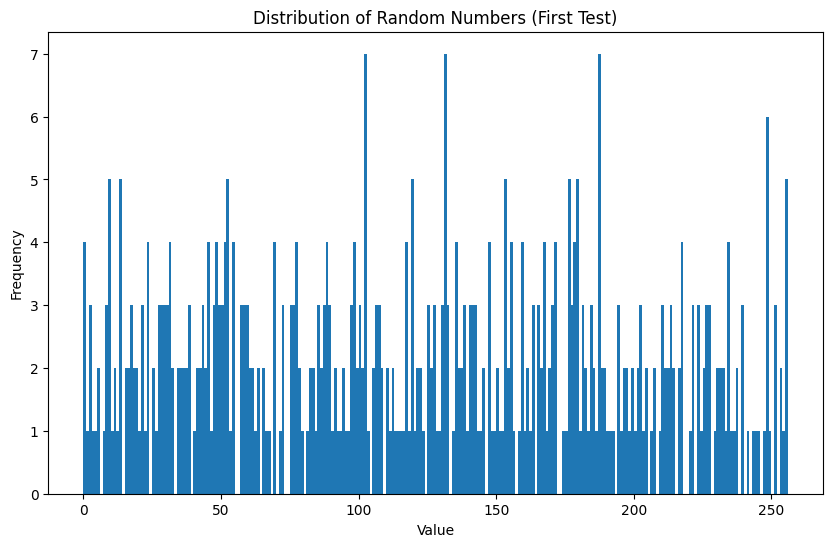

In [ ]:
import requests
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import os
import hmac
import time
from openai import OpenAI
from collections import defaultdict
import secrets
import urllib3
from scipy.stats import chisquare, pearsonr
from math import log2

urllib3.disable_warnings()

# Configuration
NOAA_URL = "https://services.swpc.noaa.gov/json/goes/primary/integral-protons-1-day.json"
NUM_SAMPLES = 500
NUM_TESTS = 100
OPENAI_API_KEY = "YOUR_API_KEY_HERE"
newkey = "YOUR_API_KEY_HERE"

# Cost assumptions (in USD)
OPENAI_COST_PER_CALL = 0.01
NOAA_COST_PER_CALL = 0.0

def calculate_shannon_entropy(bit_sequence):
    """Calculate Shannon entropy in bits per bit"""
    value_counts = defaultdict(int)
    for bit in bit_sequence:
        value_counts[bit] += 1

    entropy = 0.0
    total = len(bit_sequence)
    for count in value_counts.values():
        probability = count / total
        entropy -= probability * log2(probability)

    return entropy

def calculate_bit_balance(bit_sequence):
    """Calculate the ratio of 0s to 1s"""
    zeros = bit_sequence.count(0)
    ones = len(bit_sequence) - zeros
    return zeros, ones, zeros / len(bit_sequence) if len(bit_sequence) > 0 else 0.0

def calculate_chi_square(numbers, num_bins=256):
    """Calculate χ² test for uniformity"""
    observed, _ = np.histogram(numbers, bins=num_bins, range=(0, 256))
    expected = [len(numbers)/num_bins] * num_bins
    chi2, p = chisquare(observed, f_exp=expected)
    return p

def calculate_lag_correlation(numbers, lag=1):
    """Calculate lag-1 autocorrelation"""
    if len(numbers) <= lag:
        return 0.0
    return pearsonr(numbers[:-lag], numbers[lag:])[0]

def get_ai_entropy():
    """Get entropy from AI response with timing"""
    start_time = time.time()
    client = OpenAI(api_key=OPENAI_API_KEY)
    completion = client.chat.completions.create(
        model="gpt-4o",
        temperature=1,
        messages=[{"role": "user", "content": "Explain quantum randomness"}]
    )
    response = completion.choices[0].message.content
    elapsed = time.time() - start_time

    # Bag of words processing
    bags = defaultdict(int)
    for char in response:
        bags[char] = (bags[char] + 1) % 16

    sequence = []
    for val in bags.values():
        if 10 <= val <= 15:
            sequence.append(chr(ord('a') + val - 10))
        else:
            sequence.append(str(val))

    return ''.join(sequence), elapsed, OPENAI_COST_PER_CALL

def get_cosmic_entropy():
    """Get entropy from cosmic ray data with timing"""
    start_time = time.time()
    response = requests.get(NOAA_URL, verify=False, timeout=10)
    data = response.json()
    values = [x['flux'] for x in data if 'flux' in x]
    elapsed = time.time() - start_time

    # LSB whitening (optional)
    lsb_pool = bytes([int(x) & 0x01 for x in values])
    cosmic_bytes = str(values).encode() + lsb_pool + os.urandom(32)

    # Cryptographic hashing
    for _ in range(1000):
        cosmic_bytes = hashlib.sha3_256(cosmic_bytes).digest()

    return cosmic_bytes, elapsed, NOAA_COST_PER_CALL

def combined_prng():
    """Combined PRNG with full statistical measurement"""
    start_time = time.time()
    try:
        # Get entropy from both sources with timing
        ai_entropy, ai_time, ai_cost = get_ai_entropy()
        cosmic_entropy, cosmic_time, cosmic_cost = get_cosmic_entropy()
        ai_entropy = ai_entropy.encode()

        # Cryptographic mixing
        hmac_start = time.time()
        hmac_key = os.urandom(32)
        combined = hmac.new(hmac_key, ai_entropy + cosmic_entropy, hashlib.sha3_512).digest()
        hmac_time = time.time() - hmac_start

        # Convert to numbers and bits
        random_numbers = [x % 256 for x in combined]
        random_bits = []
        for num in random_numbers:
            random_bits.extend([int(b) for b in f"{num:08b}"])

        # Extend if needed
        while len(random_numbers) < NUM_SAMPLES:
            combined = hashlib.sha3_512(combined).digest()
            new_numbers = [x % 256 for x in combined]
            random_numbers.extend(new_numbers)
            for num in new_numbers:
                random_bits.extend([int(b) for b in f"{num:08b}"])

        # Trim to exact sample size
        random_numbers = random_numbers[:NUM_SAMPLES]
        random_bits = random_bits[:NUM_SAMPLES*8]

        # Calculate statistics
        total_time = time.time() - start_time
        total_cost = ai_cost + cosmic_cost

        # Performance metrics
        time_per_number = total_time / NUM_SAMPLES
        cost_per_number = total_cost / NUM_SAMPLES
        throughput = NUM_SAMPLES / total_time

        # Statistical metrics
        shannon_entropy = calculate_shannon_entropy(random_bits)
        zeros, ones, bit_balance = calculate_bit_balance(random_bits)
        chi2_p = calculate_chi_square(random_numbers)
        lag1_corr = calculate_lag_correlation(random_numbers)

        return {
            'numbers': random_numbers,
            'bits': random_bits,
            'metrics': {
                'performance': {
                    'total_time': total_time,
                    'time_per_number': time_per_number,
                    'total_cost': total_cost,
                    'cost_per_number': cost_per_number,
                    'throughput': throughput,
                    'component_times': {
                        'ai': ai_time,
                        'cosmic': cosmic_time,
                        'hmac': hmac_time
                    }
                },
                'statistics': {
                    'shannon_entropy': shannon_entropy,
                    'bit_balance': (zeros, ones, bit_balance),
                    'chi2_p': chi2_p,
                    'lag1_corr': lag1_corr,
                    'mean': np.mean(random_numbers),
                    'std_dev': np.std(random_numbers)
                }
            }
        }

    except Exception as e:
        print(f"Error: {e}")
        return None

def run_tests(num_tests):
    """Run multiple independent tests and aggregate results"""
    all_results = []
    all_metrics = []

    for i in range(num_tests):
        print(f"Running test {i+1}/{num_tests}...")
        result = combined_prng()
        if result:
            all_results.append(result)
            all_metrics.append(result['metrics'])

    # Calculate averages
    def avg_stats(key_path):
        return np.mean([m['statistics'][key_path] for m in all_metrics if 'statistics' in m])

    avg_metrics = {
        'performance': {
            'time_per_number': np.mean([m['performance']['time_per_number'] for m in all_metrics]),
            'cost_per_number': np.mean([m['performance']['cost_per_number'] for m in all_metrics]),
            'throughput': np.mean([m['performance']['throughput'] for m in all_metrics]),
            'total_time': np.mean([m['performance']['total_time'] for m in all_metrics]),
            'total_cost': np.mean([m['performance']['total_cost'] for m in all_metrics]),
            'component_times': {
                'ai': np.mean([m['performance']['component_times']['ai'] for m in all_metrics]),
                'cosmic': np.mean([m['performance']['component_times']['cosmic'] for m in all_metrics]),
                'hmac': np.mean([m['performance']['component_times']['hmac'] for m in all_metrics])
            }
        },
        'statistics': {
            'shannon_entropy': avg_stats('shannon_entropy'),
            'bit_balance': (
                np.mean([m['statistics']['bit_balance'][0] for m in all_metrics]),
                np.mean([m['statistics']['bit_balance'][1] for m in all_metrics]),
                np.mean([m['statistics']['bit_balance'][2] for m in all_metrics])
            ),
            'chi2_p': avg_stats('chi2_p'),
            'lag1_corr': avg_stats('lag1_corr'),
            'mean': avg_stats('mean'),
            'std_dev': avg_stats('std_dev')
        }
    }

    return all_results, avg_metrics

def print_full_metrics(metrics):
    """Print comprehensive metrics"""
    print("\n=== Performance Metrics ===")
    perf = metrics['performance']
    print(f"Average time per number: {perf['time_per_number']:.6f} seconds")
    print(f"Average cost per number: ${perf['cost_per_number']:.8f}")
    print(f"Average throughput: {perf['throughput']:.2f} numbers/second")
    print(f"\nComponent Times (seconds):")
    print(f"  AI API call: {perf['component_times']['ai']:.4f}")
    print(f"  Cosmic API call: {perf['component_times']['cosmic']:.4f}")
    print(f"  HMAC processing: {perf['component_times']['hmac']:.4f}")

    print("\n=== Statistical Metrics ===")
    stats = metrics['statistics']
    print(f"Shannon Entropy: {stats['shannon_entropy']:.4f} bits/bit (Max: 1.0)")
    print(f"Bit Balance: 0s={int(stats['bit_balance'][0])}, 1s={int(stats['bit_balance'][1])} ({stats['bit_balance'][2]*100:.2f}% 0s)")
    print(f"χ² p-value: {stats['chi2_p']:.4f} (>0.01 indicates uniformity)")
    print(f"Lag-1 Autocorrelation: {stats['lag1_corr']:.4f} (0 indicates independence)")
    print(f"Mean: {stats['mean']:.2f} (Expected: ~127.5)")
    print(f"Std Dev: {stats['std_dev']:.2f} (Expected: ~73.9)")

if __name__ == "__main__":
    print(f"Starting {NUM_TESTS} independent tests...")
    all_results, avg_metrics = run_tests(NUM_TESTS)

    if all_results:
        # Print full metrics
        print_full_metrics(avg_metrics)

        # Plot histogram from first test
        plt.figure(figsize=(10, 6))
        plt.hist(all_results[0]['numbers'], bins=256, range=(0, 256))
        plt.title("Distribution of Random Numbers (First Test)")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No successful test runs completed.")

In [ ]:
# This version combines our three PRNGs we have so far,
# results are not usually as good as previous model (particularly Shannon-Entropy score)
import requests
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import os
import hmac
from openai import OpenAI
from collections import defaultdict
from random import shuffle
import secrets
import urllib3
import sports_entropy_prng as se
urllib3.disable_warnings()

NOAA_URL = "https://services.swpc.noaa.gov/json/goes/primary/integral-protons-1-day.json"
NUM_SAMPLES = 500
OPENAI_API_KEY = "YOUR_API_KEY_HERE"

# Set sports API keys
os.environ['APISPORTS_KEY'] = "YOUR_API_KEY_HERE"
os.environ['SPORTMONKS_KEY'] = "YOUR_API_KEY_HERE"
os.environ['SPORTSDATAIO_KEY'] = "YOUR_API_KEY_HERE"


def get_sports_entropy(): # Get entropy from live sports data
    seed = se.gen_seed()
    rng = se.DRBG(seed)
    return rng.random_bytes(64)

def combined_prng(): #Combined PRNG with all three data sources
    try:
        ai_entropy = get_ai_entropy()
        cosmic_entropy = get_cosmic_entropy()
        sports_entropy = get_sports_entropy()

        # Cryptographic mixing with HMAC key (optional)
        hmac_key = os.urandom(64)  # 64 byte(512-bit) key
        combined = hmac.new(hmac_key, ai_entropy + cosmic_entropy + sports_entropy,
                           hashlib.sha3_512).digest()

        # Hashing
        for _ in range(1000):
            combined = hashlib.sha3_512(combined).digest()

        # Convert to numbers
        random_numbers = [x % 256 for x in combined]

        # Extend if needed
        while len(random_numbers) < NUM_SAMPLES:
            combined = hashlib.sha3_512(combined).digest()
            random_numbers.extend([x % 256 for x in combined])

        return random_numbers[:NUM_SAMPLES]

    except Exception as e:
        print(f"Error: {e}")
        return None

# Generate and create plots
print("Generating combined random numbers...")
random_numbers = combined_prng()


if random_numbers:
    print(f"First 20 numbers: {random_numbers[:20]}")
    print(f"Mean: {np.mean(random_numbers):.2f} (Expected: ~127.5)")
    print(f"Std Dev: {np.std(random_numbers):.2f} (Expected: ~73.9)")
    analyze_results(random_numbers)
    analyze_randomness(random_numbers)
else:
    print("Failed to generate numbers.")


Generating combined random numbers...
Error: can only concatenate str (not "bytes") to str
Failed to generate numbers.


In [ ]:
def generate_nist_input(num_bytes=1000000, output_file="nist_input.bin", chunk_size=5000):
    """Optimized generator with progress tracking"""
    with open(output_file, 'wb') as f:
        bytes_written = 0
        while bytes_written < num_bytes:
            try:
                result = combined_prng()
                if result and isinstance(result, dict):
                    chunk = bytes(result.get('numbers', os.urandom(min(chunk_size, num_bytes - bytes_written))))
                    f.write(chunk)
                    bytes_written += len(chunk)
                    print(f"Progress: {bytes_written/num_bytes:.1%}", end='\r')
            except Exception as e:
                print(f"Error: {e}, using fallback")
                f.write(os.urandom(min(chunk_size, num_bytes - bytes_written)))
    print(f"\nGenerated {bytes_written} bytes in {output_file}")

generate_nist_input(num_bytes=1000000)  # 100KB file

Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error: Error code: 429 - {'error': {'message':

In [ ]:
import os
assert os.path.getsize("nist_input.bin") == 102500